### Introduction
Epilepsy affects more than 64 million people worldwide. Despite substantial progress in the efficacy of anti-epileptic drugs, one-third of the epileptic patients continue to have seizures despite anti-epileptic medication. The unpredictable nature of seizures can be life-threatening, causing epilepsy patients to have a 2-3 times higher mortality rate than healthy control groups.

Ideally, we would like to warn patients that a seizure is going to occur, so the patient can make sure they are in a safe environment (e.g. not near sharp objects) and can get emergency medication administered by their caregiver. At the moment, the standard procedure for such epileptic patient monitoring is based on simultaneous video recordings and multiple electroencephalogram electrodes (video-EEG). However, video recordings seriously impact the patient’s privacy, and EEG measurements are invasive, requiring multiple electrodes to be attached to the patient’s head at all times. Therefore, it is not possible to monitor patients on a long-term basis and in ambulatory settings based on such video-EEG.

Wearable devices are light and only minimally invasive, so they do facilitate remote patient monitoring. For example, the e-Glass [1] is a pair of glasses that uses four EEG electrodes embedded and hidden in the temples of the glasses for real-time unobtrusive epilepsy monitoring.

![e_glasses.png](attachment:12a89b2f-c483-4a63-b7a9-07b825440d3d.png)

If we want to use the e-Glass to warn patients and caregivers, it needs to have a piece of software that analyzes the incoming EEG signals and determines whether or not the patient has a seizure at a given time.
In the three labs of this course, you will implement a machine learning system for this purpose. The labs are built up in the following way:
1.	In lab 1, you will use a Convolutional Neural Network
2.	In lab 2, you will use Resource-Aware Machine Learning
3.	In lab 3, you will use a low-power machine learning network suitable to run on wearable devices.

[1] Sopic, D., Aminifar, A., & Atienza, D. (2018, May). e-glass: A wearable system for real-time detection of epileptic seizures. In 2018 IEEE International Symposium on Circuits and Systems (ISCAS) (pp. 1-5). IEEE.


### Lab 2: Resource-Aware Federated Learning  
This week, you will use a single-lead EEG recording of one patient with epilepsy to train a random forest classifier that can classify the patient’s epileptic seizures with ~90% accuracy.

The parts that need to be filled in by you are indicated clearly with hashtags. Please **do not adjust** any of the code provided by us, unless we say it’s allowed. This may hamper the automatic grading system.
Even though you’re allowed to experiment with the order of the code, make sure that you can run the notebook from top to bottom once you hand it in.

#### A: Data inspection
We first load all python packages required for the code. In principle, these are all packages you will need for this lab, so **you’re not allowed** to import any other packages besides the ones we provide you with.

In [51]:
# Load necessary packages
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from scipy.io import loadmat
!pip install antropy
import antropy as ant
import pywt

Now, we load the dataset. This is an EEG recording of one patient with epilepsy with annotator labels. A label 1 means that the patient had an epileptic seizure in that fragment of the data, label 0 means that the patient did not have an epileptic seizure. The patient's EEG was recorded with 4 simultaneous EEG electrodes, similar to the E-Glass set-up, resulting in 2 differential EEG signals of 1024 samples each.

![image.png](attachment:04f7e2ee-f92a-49a6-add7-6d4667a81a31.png)


In the code below, you'll be provided with 'raw_data', 'labels' and 'raw_test_data'. The 'raw_data' and 'labels' are the dataset that you will use to train and validate a random forest classifier. At the end of the lab, you will use your trained random forest classifier to predict the labels of'raw_test_data'. When you hand in the lab, your predicted labels will be compared against a set of secret annotator labels by Kaggle.

In [52]:
# Load the EEG datasample of subject 05
filepath = '../input/HT-machine-learning-for-iot-2023-lab-2/patient_5.mat'
raw_data = loadmat(filepath)['raw_data']
raw_test_data = loadmat(filepath)['raw_test_data']
labels = loadmat(filepath)['labels']
print('shape of raw data vector: ',np.shape(raw_data))
print('shape of annotator labels: ',np.shape(labels))
print('shape of test data vector: ',np.shape(raw_test_data))

# To set how much data to save for validation
global_validation_ratio = 0.01

shape of raw data vector:  (231, 2048)
shape of annotator labels:  (231, 1)
shape of test data vector:  (77, 2048)


Epileptic seizures are different in every patient. One of the easiest ways to assess whether a seizure has occurred is to look at the amplitude of the signal. In this case, we define the amplitude as:

$$ amplitude(sample) = max_{i}(sample(i)) - min_{i}(sample(i)) $$

Here, the sample is one of the 231 epochs and we take the amplitude separately over both EEG signals (the first is until sample 1024, the second starts at sample 1024 and is until 2048).

**TODO: Plot the first sample of the dataset with label 1 next to the first sample of the dataset with label 0 and calculate the amplitudes of the signals.**


amplitude first electrode, label=1:  605.6166056166056
amplitude second electrode, label=1:  240.2930402930403
amplitude first electrode, label=0:  435.65323565323564
amplitude second electrode, label=0:  777.1428571428571


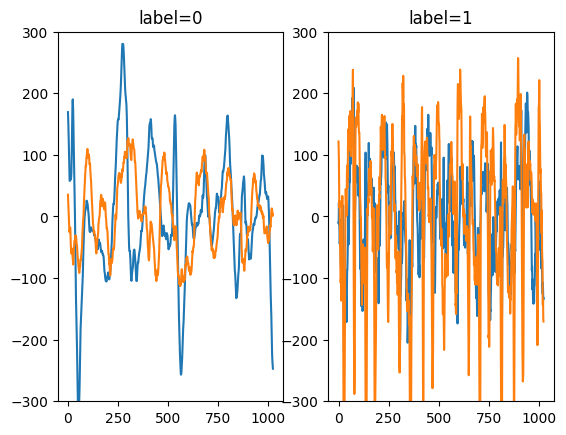

In [53]:
# find first seizure and non-seizure sample in the dataset

labels_flattened = labels.flatten()  # Flatten to 1D array
label_1_index = np.where(labels_flattened == 1)[0][0]
label_0_index = np.where(labels_flattened == 0)[0][0]

# Get the corresponding data samples
sample_1_label_1 = raw_data[label_1_index]
sample_1_label_0 = raw_data[label_0_index]

# plot the seizure and non-seizure epoch
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.set_title('label=0')
ax1.set_ylim([-300,300])
ax1.plot(sample_1_label_0[:1024]) # first electrode
ax1.plot(sample_1_label_0[1024:2048]) # second electrode
ax2.set_title('label=1')
ax2.plot(sample_1_label_1[:1024]) # first electrode
ax2.plot(sample_1_label_1[1024:2048]) # second electrode
ax2.set_ylim([-300,300])

# calculate the amplitudes
print('amplitude first electrode, label=1: ',abs(max(sample_1_label_0[:1024])-min(sample_1_label_0[:1024])))
print('amplitude second electrode, label=1: ',abs(max(sample_1_label_0[1024:2048])-min(sample_1_label_0[1024:2048])))

print('amplitude first electrode, label=0: ',abs(max(sample_1_label_1[:1024])-min(sample_1_label_1[:1024])))
print('amplitude second electrode, label=0: ',abs(max(sample_1_label_1[1024:2048])-min(sample_1_label_1[1024:2048])))

#### B: Data pre-processing
Data annotation can be a tedious process. Instead of manually inspecting the data, like you just did, we will use a machine learning algorithm to classify EEG samples into seizure (class label = 1) and non-seizure (class label = 0). In principle, the machine learning classifier tries to find a decision boundary between the two classes, such that when a new sample arrives, we can use the learned decision boundary to classify that sample.
For a two-dimensional problem with two classes, this would look something like this:

![image.png](attachment:2be82ed4-a2d1-45bc-ac9e-b53ca4289925.png)

Note that we can use a one-dimensional decision boundary (a line) to distinguish between the two classes in our two-dimensional data space. This notion extends to n-dimensional spaces: We need to use a (n-1)-dimensional decision boundary to distinguish between the two classes in a n-dimensional data space.
In real-world scenarios like our epilepsy case, n is often large. Data scientists call this the ‘curse of dimensionality’. The most commonly used method to reduce the dimensionality of a machine learning problem is feature extraction. In this lab, we investigate manual feature extraction. The idea behind manual feature extraction is that we use properties that we know are of importance to our problem to reduce the dimensionality of the problem.


![image.png](attachment:3e5c70e2-6d00-4e9b-8cb1-c37d4efea3c1.png)

In this lab, you will extract 4 power features and 22 entropy features. You will then train Random Forest 1 on the power features only, and train Random Forest 2 on all features.

### Power Features

First, you have to extract power features.

**TODO: Implement code that finds the signal power in each frequency band as specified down below (Alpha, Beta, Delta and Theta).
Then use this code to find the relative power in the following bands:**
* **[0.5 - 4  Hz] Delta Frequency band**
* **[4   - 7  Hz] Theta Frequency band**
* **[7   - 12 Hz] Alpha Frequency band**
* **[12  - 30 Hz] Beta Frequency band**

Here, the relative power is defined as:
$$ \text{rel_power}(X, band, fs) = \frac{ power(X, band, fs)} {power(X, [0.5-30], fs)} $$
So, the relative power is the power of the specified frequency band divided by the total power of the signal between 0.5 and 30 Hz. Since you have to compute the relative frequency of 4 frequency bands, you'll end up with 4 power features per data sample.

Note: There's a function in numpy called np.fft.fft that you can use to calculate the Fourier Transform of your input signal X.

In [54]:
# Define your feature(s)
def rel_power(X, band, fs):
    """Compute power of input sample X with sampling frequency fs in each frequency bin specified by band
    Parameters
    -----------
    band
        list
        boundary frequencies (in Hz) of bins.
     X
        list
        a 1-D real time series.
    fs
        integer
        the sampling rate in physical frequency
    Returns
    -------
    power_ratio
        list
        spectral power in each frequency bin normalized by total power in ALL
        frequency bins.
    """

    # Translate to the frequency domain, we perform a fast fourier transform. FFT is now a (2048,) array
    FFT = np.fft.fft(X)
    
    # Calculate signal power ratio in frequency domain
    power = np.abs(FFT) ** 2

    # Calculate total power between 0.5 and 30 Hz.
    # Compensate by dividing by sampling frequency, so that the data array represents one second of real life time
    # [0.5/fs] to [30/fs] represents a smale slice, now multiply by length of data (len of power) to sum the correct datapoints. 
    total_power = np.sum(power[int(0.5/fs*len(power)):int(30/fs*len(power))])

    # Initialize an array to store the relative power in different frequency bands
    power_ratio = []

    for b in band:
        start, end = b
        # Calculate power in the specified frequency band
        band_power = np.sum(power[int(start/fs*len(power)):int(end/fs*len(power))])
        # Calculate the relative power in the band
        relative_power = band_power / total_power
        power_ratio.append(relative_power)

    return power_ratio

# Extract your feature(s) from the raw data
fs = 256 # Hz, the sampling frequency when collecting the dataset. 
#As each sample has 1024 datapoints, it took 1024/256 = 4 seconds to collect a sample in real life.

# Define the EEG frequency bands
band = [(0.5, 4), (4, 7), (7, 12), (12, 30)]

power_features = np.zeros((len(raw_data),4))

### TODO: Calculate power features of raw_data vector and store it in the power_features array
#X = np.array(raw_data).flatten()

# Calculate power features and store them in power_features array
for i, sample in enumerate(raw_data):
  power_feature = np.array(rel_power(np.array(sample).flatten(), band, fs))
  power_features[i][:] = power_feature

print("For the first sample, the power features are: ", power_features[0])
print("The sum of power features for one sample should equal 1. It sums to: ", sum(power_features[0]))

For the first sample, the power features are:  [0.30456574 0.36745728 0.15415368 0.1738233 ]
The sum of power features for one sample should equal 1. It sums to:  1.0


Now, we split the dataset in a training and test dataset.

In [55]:
# Define a training and testing dataset
train_data, validation_data, train_labels, validation_labels= train_test_split(power_features,labels,
                                                    random_state=42,test_size=global_validation_ratio)

# Print the shape of the train and validation dataset and labels
print('train data shape:',np.shape(train_data))
print('validation data shape:',np.shape(validation_data))
print('train labels shape:',np.shape(train_labels))
print('validation labels shape:',np.shape(validation_labels))

train data shape: (228, 4)
validation data shape: (3, 4)
train labels shape: (228, 1)
validation labels shape: (3, 1)


#### C: Model training
Now, we can apply the random forest classifier from SKlearn to the training dataset. For more information about how random forest classfiers work, check [this](http://youtu.be/J4Wdy0Wc_xQ) video.

In [56]:
# Initialize the RF classifier
RF1 = RandomForestClassifier(n_estimators=100)
np.random.seed(1234) #set seed: Don't touch this!

# Fit the RF classifier on the dataset
RF1.fit(train_data,np.ravel(train_labels))

RandomForestClassifier()

#### D: Model evaluation

Once the RF model is trained, we can evaluate its performance.

**TODO: Evaluate the performance on the training and validation dataset using the clf.predict() command and calculate the accuracy on the training and testing dataset.**


In [57]:
# predict the labels for the training and validation set
predicted_labels_train = RF1.predict(train_data)
predicted_labels_val = RF1.predict(validation_data)

# compute the accuracy of the predicted labels
accuracy_train = accuracy_score(train_labels, predicted_labels_train)
print("Training Accuracy:", accuracy_train*100, "%")
accuracy_val =  accuracy_score(validation_labels, predicted_labels_val)
print("Validation Accuracy:", accuracy_val*100, "%")

Training Accuracy: 99.56140350877193 %
Validation Accuracy: 100.0 %


**TODO: Please compute the confusion matrix of RF1 on the validation dataset**

In [58]:
def compute_confusion_matrix(true_labels, predicted_labels):

    unique_labels = np.unique(true_labels)
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    for i in range(len(true_labels)):
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        true_label_index = np.where(unique_labels == true_label)[0][0]
        predicted_label_index = np.where(unique_labels == predicted_label)[0][0]
        confusion_matrix[true_label_index][predicted_label_index] += 1

    return confusion_matrix

# Compute the confusion matrix
confusion_matrix = compute_confusion_matrix(validation_labels, predicted_labels_val)

for row in confusion_matrix:
    print(' '.join(['{:4}'.format(int(item)) for item in row]))

   2    0
   0    1


#### E: Entropy Features

Next to power features, it's also known that entropy plays an important role in epilepsy detection. Entropy is related to the amount of information contained in the signal. For the purpose of this lab, you don't have to understand what entropy is, so we provide you with code to extract the entropy features. If you execute the segment down below, you will end up with 22 entropy features.

In [59]:
# normalize the data
maxs = np.reshape(np.max(raw_data,axis=1),[231,1])
maxj = np.tile(maxs,(1,2048))
data_normalized = raw_data / maxj
# extract discrete wavelet transform
dwt = pywt.wavedec(data_normalized, 'db4',level=6)

# calculate sample entropy, permutation entropy and shannon entropy of the signal
sample_entropies = np.zeros((len(data_normalized),2))
permutation_entropies = np.zeros((len(data_normalized),15)) # dwt 3, 4, 5, 6, 7 and n 3, 5, 7
shannon_entropies = np.zeros((len(data_normalized),5)) # dwt 3, 4, 5, 6, 7
for i in range(len(data_normalized)):
    sample_entropies[i,0] = ant.sample_entropy(dwt[5][i,:], order=2)
    sample_entropies[i,1] = ant.sample_entropy(dwt[6][i,:], order=2)
    k = 0
    for j in [2, 3, 4, 5, 6]:
        shannon_entropies[i,k] = ant.spectral_entropy(dwt[j][i,:], sf=256, normalize=True)
        permutation_entropies[i,k] = ant.perm_entropy(dwt[j][i,:], order=3, normalize=True)
        permutation_entropies[i,5 + k] = ant.perm_entropy(dwt[j][i,:], order=5, normalize=True)
        permutation_entropies[i,10 + k] = ant.perm_entropy(dwt[j][i,:], order=7, normalize=True)
        k += 1

**TODO: Train Random Forest 2 on all calculated features and calculate the accuracy**


In [60]:
# RandomForest2 will be trained on both teh 4 power features and the 22 entropy features
combined_entropies = np.hstack((permutation_entropies, shannon_entropies, sample_entropies, power_features))
print(combined_entropies.shape)

(231, 26)


In [62]:
train_data, validation_data, train_labels, validation_labels= train_test_split(combined_entropies ,labels,
                                                    random_state=42,test_size=global_validation_ratio)

# Initialize the RF classifier
RF2 = RandomForestClassifier(n_estimators=100)
np.random.seed(1234) #set seed: Don't touch this!

# Fit the RF classifier on the dataset
RF2.fit(train_data,np.ravel(train_labels))

# predict the labels for the training and validation set
predicted_labels = RF2.predict(train_data)
predicted_labels_val = RF2.predict(validation_data)

# compute the accuracy of the predicted labels
accuracy_train = accuracy_score(train_labels, predicted_labels_train)
print("Training Accuracy:", accuracy_train, "%")
accuracy_val = accuracy_score(validation_labels, predicted_labels_val)
print("Validation Accuracy:", accuracy_val, "%")

Training Accuracy: 0.9956140350877193 %
Validation Accuracy: 1.0 %


#### F: Two-stage Inference

In Internet of Things (IoT) applications, the computational resources we have access to are often limited. This means that we can't put all of the client's data through RF2, since calculating entropy features is computationally intensive and performing inference with 26 features is also more intensive than doing inference with 4 features. Because of this, you're going to implement a two-stage inference method that finds a good trade-off between (increased) computational complexity and performance. An overview of two-stage inference is displayed in the image below:

![image.png](attachment:889514ad-0c27-4fbe-afa0-cb091da55010.png)

For every sample in raw_test_data, we:
1. Extract power features
2. Pass the power features through the trained RF1 network
3. If more than TH out of 100 trees agree on a label, this label is passed on to the predicted_label_test vector and we continue with the next test sample. However, if less than TH out of 100 trees agree on a label, we continue with steps 4 and 5:
4. Extract entropy features
5. Feed all features through RF2 and pass the predicted label on to the predicted_label_test vector

**TODO: implement this two-level classifier and use it to compute the predicted_label_test vector**

In [63]:
complexity = 0 # This parameter records the complexity of your algorithm
# 1. Extract power features on the test set
power_features_test = np.zeros((len(raw_test_data),4))
print("raw_test_data ", raw_test_data.shape)
print("power_features_test ", power_features_test.shape)

for i, sample in enumerate(raw_test_data):
  power_feature = np.array(rel_power(np.array(sample).flatten(), band, fs))
  power_features_test[i][:] = power_feature

# 2. Pass the power features through the trained RF1 network
predicted_label_test = RF1.predict(power_features_test)
print("predicted_label_test ", predicted_label_test.shape)

# 3. Calculate the number of trees that agree with the predicted label and determine if sample is above threshold
trees_agreement = RF1.predict_proba(power_features_test)*100
print("trees_agreement ", trees_agreement.shape)

TH = 80  # set a threshold for the number of trees that should be in agreement
for ii in range(len(predicted_label_test)):
    print("trees_agreement[ii] with ii = ", ii, " is ", trees_agreement[ii])
    if np.max(trees_agreement[ii]) < TH:
        #4. Extract entropy features
        normalized_data = raw_test_data[ii,:] / np.max(raw_test_data[ii,:]) #normalize
        dwt = pywt.wavedec(normalized_data, 'db4', level=6)
        sample_entropy = np.zeros((1,2))
        permutation_entropy = np.zeros((1,15))
        shannon_entropy = np.zeros((1,5))
        sample_entropy[0,0] = ant.sample_entropy(dwt[5],order=2)
        sample_entropy[0,1] = ant.sample_entropy(dwt[6],order=2)
        k = 0
        for j in [2, 3, 4, 5, 6]:
            shannon_entropy[0,k] = ant.spectral_entropy(dwt[j], sf=256, normalize=True)
            permutation_entropy[0,k] = ant.perm_entropy(dwt[j], order=3, normalize=True)
            permutation_entropy[0,5 + k] = ant.perm_entropy(dwt[j], order=5, normalize=True)
            permutation_entropy[0,10 + k] = ant.perm_entropy(dwt[j], order=7, normalize=True)
            k += 1
            
        #print("permutation_entropy",permutation_entropy.shape)
        #print("shannon_entropy",shannon_entropy.shape)
        #print("sample_entropy",sample_entropy.shape)
        
        reshaped_power_features_test = power_features_test[ii].reshape(1,-1)
        all_features_test = np.hstack((permutation_entropy, shannon_entropy, sample_entropy,reshaped_power_features_test))

        # 5. Feed all features through RF2
        predicted_label_test[ii] = RF2.predict(all_features_test)

        complexity += 1  #since you've used the more complex RF2 classifier, this adds to the complexity

# collect all of the labels in the vector predicted_labels_test
predicted_labels_test = predicted_label_test # desired shape: 77x1
predicted_labels_test.shape

raw_test_data  (77, 2048)
power_features_test  (77, 4)
predicted_label_test  (77,)
trees_agreement  (77, 2)
trees_agreement[ii] with ii =  0  is  [100.   0.]
trees_agreement[ii] with ii =  1  is  [62. 38.]
trees_agreement[ii] with ii =  2  is  [42. 58.]
trees_agreement[ii] with ii =  3  is  [85. 15.]
trees_agreement[ii] with ii =  4  is  [26. 74.]
trees_agreement[ii] with ii =  5  is  [86. 14.]
trees_agreement[ii] with ii =  6  is  [  0. 100.]
trees_agreement[ii] with ii =  7  is  [96.  4.]
trees_agreement[ii] with ii =  8  is  [100.   0.]
trees_agreement[ii] with ii =  9  is  [ 5. 95.]
trees_agreement[ii] with ii =  10  is  [30. 70.]
trees_agreement[ii] with ii =  11  is  [  0. 100.]
trees_agreement[ii] with ii =  12  is  [92.  8.]
trees_agreement[ii] with ii =  13  is  [100.   0.]
trees_agreement[ii] with ii =  14  is  [100.   0.]
trees_agreement[ii] with ii =  15  is  [100.   0.]
trees_agreement[ii] with ii =  16  is  [100.   0.]
trees_agreement[ii] with ii =  17  is  [ 1. 99.]
tree

(77,)

### G: Submission

For submission, run the code below and follow the instructions provided in Canvas: https://canvas.education.lu.se/courses/26470/pages/laboratory-assignment-2?module_item_id=983790
You will pass the lab **if your score on the Kaggle leaderboard is equal to or above 90%**.

In [64]:
# Reformat so that every question is weighed equally
Q61 = []
for x in range(len(predicted_labels_test)):
    if x < complexity :
        Q61.append(1)
    else:
        Q61.append(0)
print(Q61)
Q71 = [int(x) for x in predicted_labels_test.flatten()]
submission_array = np.concatenate((Q61,Q71,Q71,Q71,Q71,Q71,Q71,Q71,Q71,Q71,Q71))

# Save as a pandas dataframe
x = [i for i in range(1,len(submission_array)+1)]
d = {'Id':x,'Category': submission_array}
df = pd.DataFrame(data=d)
print(df)
file_name = 'submission.csv'
df.to_csv(file_name, sep=',',index=False)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      Id  Category
0      1         1
1      2         1
2      3         1
3      4         1
4      5         1
..   ...       ...
842  843         0
843  844         1
844  845         0
845  846         0
846  847         0

[847 rows x 2 columns]
